# Building a micro grid system with a renewable share constraint

The energy system model was generated in yesterdays tutorial "2_tutorial_micro_grid.ipynb". It can be described as following:

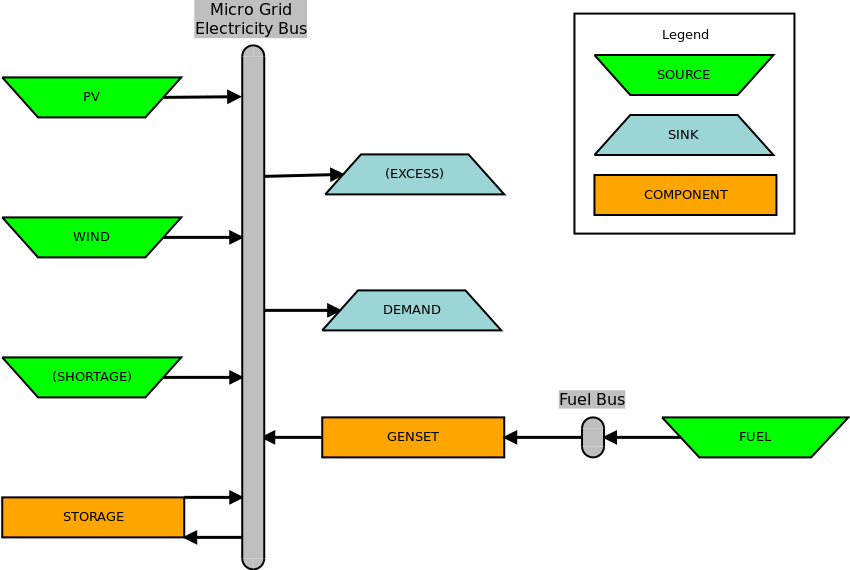

Even when adding a customized constraint to an oemof model, the initial model building is identical:

In [1]:
# importing packages
import os
import pandas as pd
from matplotlib import pyplot as plt

import oemof.solph as solph
from oemof.solph import constraints
import oemof.outputlib as outputlib
from oemof.tools import economics
from oemof.tools import logger #logger to document progress
import logging

# Define screen level of logger
logger.define_logging(screen_level=logging.INFO)

# initialize energy system
duration_hours = 24
cost_ratio_timeinterval = duration_hours/(365*24)
timeindex = pd.date_range('1/1/2017', periods=duration_hours, freq='H')
energysystem = solph.EnergySystem(timeindex=timeindex)

# loading input data
logging.info('Loading timeseries')
full_filename = '2_timeseries.csv'
timeseries = pd.read_csv(full_filename, sep=',')

# Defining fix parameters
logging.info('Defining costs')

fuel_price_kWh = 0.6/9.41 # fuel price in currency/kWh

costs = {'wind': {
             'epc': economics.annuity(capex=2000, n=20, wacc=0.05)*cost_ratio_timeinterval},
         'pv': {
             'epc': economics.annuity(capex=750, n=20, wacc=0.05)*cost_ratio_timeinterval},
         'genset': {
             'epc': economics.annuity(capex=300, n=10, wacc=0.05)*cost_ratio_timeinterval,
             'var': 0},
         'storage': {
             'epc': economics.annuity(capex=400, n=5, wacc=0.05)*cost_ratio_timeinterval,
             'var': 0}}

print('\n')

# Creating all oemof components
logging.info('DEFINITION OF OEMOF MODEL:')

logging.info('Electricity bus')
bel = solph.Bus(label='electricity_bus')
energysystem.add(bel)

logging.info('Demand, fixed timeseries')
demand_sink = solph.Sink(label='demand',
                         inputs={bel: solph.Flow(actual_value=timeseries['demand_el'],
                                                 fixed=True,
                                                 nominal_value=500)})
energysystem.add(demand_sink)

logging.info('Excess sink')
excess_sink = solph.Sink(label='excess',
                    inputs={bel: solph.Flow()})
energysystem.add(excess_sink)

logging.info('Wind plant with fixed feed-in timeseries')
wind_plant = solph.Source(label='wind',
                          outputs={
                              bel: solph.Flow(nominal_value=None,
                                              fixed=True,
                                              actual_value=timeseries['wind'],
                                              investment=solph.Investment(
                                                  ep_costs=costs['wind']['epc']))})
energysystem.add(wind_plant)

logging.info('PV plant with fixed feed-in timeseries')
pv_plant = solph.Source(label='pv',
                        outputs={
                            bel: solph.Flow(nominal_value=None,
                                            fixed=True,
                                            actual_value=timeseries['pv'],
                                            investment=solph.Investment(
                                                ep_costs=costs['pv']['epc']))})

energysystem.add(pv_plant)

logging.info('Diesel fuel bus, source and transformer')
bfuel = solph.Bus(label='fuel_bus')

fuel_source = solph.Source(label='diesel',
       outputs={
           bfuel: solph.Flow(nominal_value=None,
                             variable_costs=fuel_price_kWh)}
       )

genset = solph.Transformer(label="genset",
                           inputs={bfuel: solph.Flow()},
                           outputs={bel: solph.Flow(
                               variable_costs=costs['genset']['var'],
                               investment=solph.Investment(
                                   ep_costs=costs['genset']['epc']))},
                           conversion_factors={bel: 0.33}
                           )

energysystem.add(bfuel, fuel_source, genset)

logging.info('Battery storage')
storage = solph.components.GenericStorage(
    label='storage',
    inputs={
        bel: solph.Flow()},
    outputs={
        bel: solph.Flow()},
    loss_rate=0.00,
    initial_storage_level=0.5, 
    invest_relation_input_capacity=1/5,
    invest_relation_output_capacity=1,
    inflow_conversion_factor=0.95,
    outflow_conversion_factor=0.95,
    investment=solph.Investment(ep_costs=costs['storage']['epc']))

energysystem.add(storage)

print('\n')
logging.info('Generating linear equation system describing defined energy system')
model = solph.Model(energysystem)

07:31:15-INFO-Path for logging: /home/mh/.oemof/log_files/oemof.log
07:31:15-INFO-Used oemof version: 0.3.1
07:31:15-INFO-Loading timeseries
07:31:15-INFO-Defining costs


07:31:15-INFO-DEFINITION OF OEMOF MODEL:
07:31:15-INFO-Electricity bus
07:31:15-INFO-Demand, fixed timeseries
07:31:15-INFO-Excess sink
07:31:15-INFO-Wind plant with fixed feed-in timeseries
07:31:15-INFO-PV plant with fixed feed-in timeseries
07:31:15-INFO-Diesel fuel bus, source and transformer
07:31:15-INFO-Battery storage


07:31:15-INFO-Generating linear equation system describing defined energy system


Instead of directly processing and solving the linear equation system with the solver, we now add our renewable share constraint. For that, we have to define a function describing the renewable share criterion:

In [2]:
import pyomo.environ as po

def renewable_share_criterion(model, genset, pv_plant, wind_plant, bel, min_renewable_share):
    def renewable_share_rule(model):  
        total_renewable_generation =  sum(model.flow[pv_plant, bel, :])
        total_renewable_generation +=  sum(model.flow[wind_plant, bel, :])
        total_generation = total_renewable_generation 
        total_generation += sum(model.flow[genset, bel, :])
            
        expr = total_renewable_generation - total_generation * min_renewable_share
        logging.info('Expression generated: %s', expr)
        return expr >= 0

    model.renewable_share_constraint = po.Constraint(rule=renewable_share_rule)

    return model

In [3]:
min_renewable_share = 0.5
renewable_share_criterion(model, genset, pv_plant, wind_plant, bel, min_renewable_share)

07:31:15-INFO-Expression generated: flow[pv,electricity_bus,0] + flow[pv,electricity_bus,1] + flow[pv,electricity_bus,2] + flow[pv,electricity_bus,3] + flow[pv,electricity_bus,4] + flow[pv,electricity_bus,5] + flow[pv,electricity_bus,6] + flow[pv,electricity_bus,7] + flow[pv,electricity_bus,8] + flow[pv,electricity_bus,9] + flow[pv,electricity_bus,10] + flow[pv,electricity_bus,11] + flow[pv,electricity_bus,12] + flow[pv,electricity_bus,13] + flow[pv,electricity_bus,14] + flow[pv,electricity_bus,15] + flow[pv,electricity_bus,16] + flow[pv,electricity_bus,17] + flow[pv,electricity_bus,18] + flow[pv,electricity_bus,19] + flow[pv,electricity_bus,20] + flow[pv,electricity_bus,21] + flow[pv,electricity_bus,22] + flow[pv,electricity_bus,23] + flow[wind,electricity_bus,0] + flow[wind,electricity_bus,1] + flow[wind,electricity_bus,2] + flow[wind,electricity_bus,3] + flow[wind,electricity_bus,4] + flow[wind,electricity_bus,5] + flow[wind,electricity_bus,6] + flow[wind,electricity_bus,7] + flow[w

In [4]:
logging.info('Saving linear equation system to file.')
model.write('./output_lp_files/2_micro_grid_custom_summed_limit.lp', io_options={'symbolic_solver_labels': True})

07:31:16-INFO-Saving linear equation system to file.


('./output_lp_files/2_micro_grid_custom_summed_limit.lp', 140553333225120)

Now we optimize and post-process the results:

In [5]:
logging.info('Starting oemof-optimization of capacities')
model.solve(solver='cbc', solve_kwargs={'tee': False})

logging.info('Processing results')
results = outputlib.processing.results(model)

07:31:16-INFO-Starting oemof-optimization of capacities
07:31:16-INFO-Optimization successful...
07:31:16-INFO-Processing results


In [6]:
el_bus = outputlib.views.node(results, 'electricity_bus')

logging.info('Get optimized capacities')
cap_wind = el_bus['scalars'][(('wind', 'electricity_bus'), 'invest')]
cap_pv = el_bus['scalars'][(('pv', 'electricity_bus'), 'invest')]
cap_genset = el_bus['scalars'][(('genset', 'electricity_bus'), 'invest')]

storage_bus = outputlib.views.node(results, 'storage')
cap_storage = storage_bus['scalars'][(('storage','None'), 'invest')]

logging.info('Capacities optimized: Storage (' + str(cap_storage)
             + '), Wind (' + str(cap_wind)
             + '), PV (' + str(cap_pv)
             + '), Genset (' + str(cap_genset) + ').')

07:31:16-INFO-Get optimized capacities
07:31:16-INFO-Capacities optimized: Storage (188.62402), Wind (1141.0732), PV (646.73278), Genset (85.429065).


07:31:16-INFO-Plot flows on electricity bus


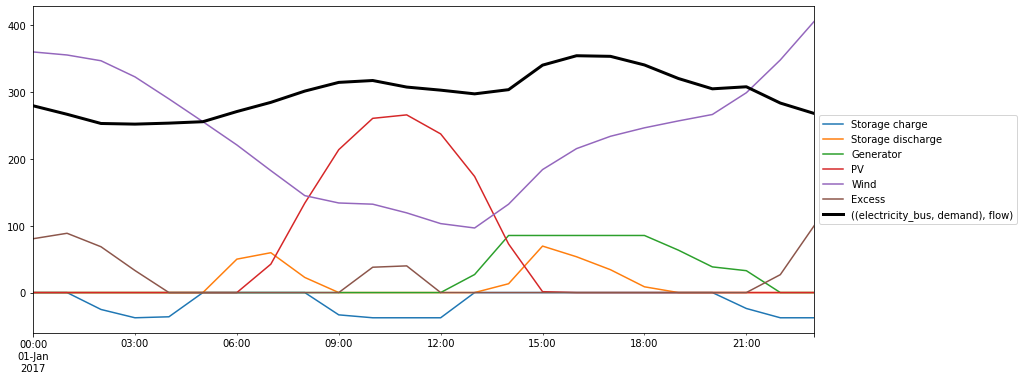

In [7]:
logging.info('Plot flows on electricity bus')
el_sequences = el_bus['sequences']

el_prod = pd.DataFrame(index=timeindex)
el_prod['Storage charge'] = - el_sequences[(('electricity_bus', 'storage'), 'flow')].clip(lower=0)
el_prod['Storage discharge'] = el_sequences[(('storage', 'electricity_bus'), 'flow')].clip(lower=0)
el_prod['Generator']=el_sequences[(('genset', 'electricity_bus'), 'flow')]
el_prod['PV']=el_sequences[(('pv', 'electricity_bus'), 'flow')]
el_prod['Wind']=el_sequences[(('wind', 'electricity_bus'), 'flow')]
el_prod['Excess']=el_sequences[(('electricity_bus', 'excess'), 'flow')]

fig, ax = plt.subplots(figsize=(14, 6))
# line plot
el_prod.plot(ax=ax)
# area plot
#el_prod.plot.area(ax=ax)
el_sequences[(('electricity_bus', 'demand'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

Check whether constraint is fullfilled by calculating renewable share:

In [8]:
renewable_generation = sum(el_bus['sequences'][(('wind', 'electricity_bus'), 'flow')])
renewable_generation += sum(el_bus['sequences'][(('pv', 'electricity_bus'), 'flow')]) 
total_generation = renewable_generation + sum(el_bus['sequences'][(('genset', 'electricity_bus'), 'flow')]) 

renewable_share = renewable_generation/total_generation

if  renewable_share >= min_renewable_share:
    print('Constraint fullfilled, renewable share at ' + str(round(renewable_share*100, 1)) + '%.')
else:
    print('Constraint failed, renewable share at ' + str(round(renewable_share*100, 1)) + '%.')

Constraint fullfilled, renewable share at 92.3%.
